In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 500)

In [2]:
data = pd.read_csv('./data.csv')
data

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,668881,R,FB,field_out,InPlay,14.54220,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,668881,R,FB,NaN,BallCalled,14.25380,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,668881,R,SL,single,InPlay,5.56877,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,668881,R,SL,NaN,FoulBall,4.80541,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,668881,R,SL,NaN,BallCalled,4.13239,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,9,4,2,2,1,0,1,0,0,643361,R,FB,NaN,StrikeCalled,15.72580,-8.54239,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,0.750023,3.40322
9885,28642,9,4,3,2,1,1,1,0,0,643361,R,CF,NaN,BallCalled,10.86980,0.60670,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,0.872825,3.17087
9886,22664,9,4,4,2,2,1,1,0,0,643361,R,FB,NaN,FoulBall,14.10840,-10.84110,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,-0.988207,2.56097
9887,22665,9,4,5,2,2,2,1,0,0,643361,R,CH,double,InPlay,10.49140,-13.44000,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,-0.278290,2.14642


In [3]:
data.isna().sum()

PID                             0
INNING_KEY                      0
BATTER_IN_INNING_KEY            0
PITCH_NUMBER                    0
OUT_KEY                         0
BALLS                           0
STRIKES                         0
IS_RUNNER_ON_1B                 0
IS_RUNNER_ON_2B                 0
IS_RUNNER_ON_3B                 0
PITCHER_KEY                     0
THROW_SIDE_KEY                  0
PITCH_TYPE_TRACKED_KEY          0
EVENT_RESULT_KEY             7258
PITCH_RESULT_KEY                0
INDUCED_VERTICAL_BREAK          0
HORIZONTAL_BREAK                0
SPIN_RATE_ABSOLUTE              0
RELEASE_SPEED                   0
RELEASE_SIDE                    0
RELEASE_HEIGHT                  0
RELEASE_EXTENSION               0
HORIZONTAL_APPROACH_ANGLE       0
VERTICAL_APPROACH_ANGLE         0
PLATE_X                         0
PLATE_Z                         0
dtype: int64

In [4]:
data['EVENT_RESULT_KEY'].value_counts()

field_out                     1041
strikeout                      547
single                         348
walk                           215
double                         118
home_run                       113
grounded_into_double_play       43
force_out                       41
hit_by_pitch                    38
stolen_base_2b                  33
sac_fly                         16
wild_pitch                      16
fielders_choice                 12
triple                          10
field_error                      9
caught_stealing_2b               7
sac_bunt                         5
stolen_base_3b                   4
double_play                      3
passed_ball                      3
catcher_interf                   2
fielders_choice_out              2
strikeout_double_play            2
pickoff_caught_stealing_2b       1
pickoff_caught_stealing_3b       1
sac_fly_double_play              1
Name: EVENT_RESULT_KEY, dtype: int64

Need to standardize the Pitcher Handedness to remove THROW_SIDE_KEY from context.
Attributes affected by handedness are,
- HORIZONTAL_BREAK
- RELEASE_SIDE
- HORIZONTAL_APPROACH_ANGLE

To handle this I will flip the sign for the above attributes for Left handed pitchers.


In [5]:
data['THROW_SIDE_KEY'].value_counts()

R    7268
L    2621
Name: THROW_SIDE_KEY, dtype: int64

In [6]:
data[data['THROW_SIDE_KEY']=='R'].head()

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,668881,R,FB,field_out,InPlay,14.54220,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,668881,R,FB,NaN,BallCalled,14.25380,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,668881,R,SL,single,InPlay,5.56877,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,668881,R,SL,NaN,FoulBall,4.80541,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,668881,R,SL,NaN,BallCalled,4.13239,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222


In [7]:
data[data['THROW_SIDE_KEY']=='L'].head()

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
91,853,4,8,1,2,0,0,1,0,1,622065,L,SI,NaN,BallCalled,5.71955,15.01870,2290.459961,90.039597,2.50245,5.76634,6.38,0.490438,-7.11470,1.586850,1.71127
92,1288,4,8,2,2,1,0,1,0,1,622065,L,SI,NaN,BallCalled,8.01106,13.99320,2297.459961,89.365303,2.41755,5.83711,6.27,1.046850,-6.37744,2.110980,2.30299
93,1660,4,8,3,2,2,0,1,0,1,622065,L,SW,NaN,StrikeCalled,5.86069,-8.58779,2435.459961,80.308601,2.48718,5.78040,5.67,-3.995770,-7.39647,-0.457471,2.29078
94,340,4,8,4,2,2,1,1,0,1,622065,L,SI,NaN,FoulBall,9.02895,13.44720,2274.459961,90.045700,2.32513,5.88397,6.29,-0.998155,-6.19902,0.172570,2.41160
95,1661,4,8,5,2,2,2,1,0,1,622065,L,CH,strikeout,StrikeSwinging,4.05789,13.77940,1479.459961,86.440102,2.18692,6.02534,6.18,-0.635472,-8.10310,0.344497,1.45486


In [8]:
data['HORIZONTAL_BREAK'] = data.apply(lambda x: -x['HORIZONTAL_BREAK'] if x['THROW_SIDE_KEY'] == 'L' else x['HORIZONTAL_BREAK'], axis=1)
data['RELEASE_SIDE'] = data.apply(lambda x: -x['RELEASE_SIDE'] if x['THROW_SIDE_KEY'] == 'L' else x['RELEASE_SIDE'], axis=1)
data['HORIZONTAL_APPROACH_ANGLE'] = data.apply(lambda x: -x['HORIZONTAL_APPROACH_ANGLE'] if x['THROW_SIDE_KEY'] == 'L' else x['HORIZONTAL_APPROACH_ANGLE'], axis=1)

In [9]:
data[data['THROW_SIDE_KEY']=='L'].head()

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
91,853,4,8,1,2,0,0,1,0,1,622065,L,SI,NaN,BallCalled,5.71955,-15.01870,2290.459961,90.039597,-2.50245,5.76634,6.38,-0.490438,-7.11470,1.586850,1.71127
92,1288,4,8,2,2,1,0,1,0,1,622065,L,SI,NaN,BallCalled,8.01106,-13.99320,2297.459961,89.365303,-2.41755,5.83711,6.27,-1.046850,-6.37744,2.110980,2.30299
93,1660,4,8,3,2,2,0,1,0,1,622065,L,SW,NaN,StrikeCalled,5.86069,8.58779,2435.459961,80.308601,-2.48718,5.78040,5.67,3.995770,-7.39647,-0.457471,2.29078
94,340,4,8,4,2,2,1,1,0,1,622065,L,SI,NaN,FoulBall,9.02895,-13.44720,2274.459961,90.045700,-2.32513,5.88397,6.29,0.998155,-6.19902,0.172570,2.41160
95,1661,4,8,5,2,2,2,1,0,1,622065,L,CH,strikeout,StrikeSwinging,4.05789,-13.77940,1479.459961,86.440102,-2.18692,6.02534,6.18,0.635472,-8.10310,0.344497,1.45486


Just keeping independent variables (fixed effects) that affect Induced Vertical Break and Horizontal Break. For random effect we can take the Pitcher ID and maybe the pitch_type in context?

In [10]:
data = data.loc[:,['PID', 'PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY', 'SPIN_RATE_ABSOLUTE',
       'RELEASE_SPEED', 'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE','INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK']]
data

,PID,PITCHER_KEY,PITCH_TYPE_TRACKED_KEY,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK
0,197,668881,FB,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,14.54220,-12.36030
1,348,668881,FB,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,14.25380,-10.95030
2,1072,668881,SL,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,5.56877,4.35335
3,420,668881,SL,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,4.80541,4.27254
4,198,668881,SL,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,4.13239,1.62418
...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,643361,FB,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,15.72580,-8.54239
9885,28642,643361,CF,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,10.86980,0.60670
9886,22664,643361,FB,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,14.10840,-10.84110
9887,22665,643361,CH,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,10.49140,-13.44000


In [11]:
data['PITCHER_KEY'].value_counts()

668933    1187
671096     776
682227     724
596133     676
668881     516
594902     494
666157     463
571656     434
664747     427
518585     413
664139     401
608371     394
571882     387
622065     334
643361     255
650960     186
570666     184
665665     176
686651     171
674285     148
668984     144
656818     135
594580     106
683175      95
680689      94
611093      91
686730      87
641427      65
592741      42
664028      42
592527      41
621219      40
669270      37
622088      36
691094      34
571912      29
613564      25
Name: PITCHER_KEY, dtype: int64

In [12]:
data['PITCH_TYPE_TRACKED_KEY'].value_counts()

FB    3295
SW    1716
CF    1307
CH    1198
SL     909
SI     815
CB     469
SF     173
UN       4
KN       3
Name: PITCH_TYPE_TRACKED_KEY, dtype: int64

In [13]:
data.groupby('PITCHER_KEY')['PITCH_TYPE_TRACKED_KEY'].value_counts()

PITCHER_KEY  PITCH_TYPE_TRACKED_KEY
518585       SF                        151
             SL                        136
             FB                        123
             UN                          3
570666       SL                         63
                                      ... 
686730       CH                         10
691094       SI                         10
             SL                          9
             CH                          8
             CF                          7
Name: PITCH_TYPE_TRACKED_KEY, Length: 157, dtype: int64

In [14]:
data

,PID,PITCHER_KEY,PITCH_TYPE_TRACKED_KEY,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK
0,197,668881,FB,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,14.54220,-12.36030
1,348,668881,FB,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,14.25380,-10.95030
2,1072,668881,SL,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,5.56877,4.35335
3,420,668881,SL,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,4.80541,4.27254
4,198,668881,SL,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,4.13239,1.62418
...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,643361,FB,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,15.72580,-8.54239
9885,28642,643361,CF,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,10.86980,0.60670
9886,22664,643361,FB,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,14.10840,-10.84110
9887,22665,643361,CH,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,10.49140,-13.44000


In [15]:
# Class fitting the Mixed LM for Induced Vertical Break and Horizontal Break each
class Model:
    def __init__(self, fit_param, data):
        self.data = data
        self.fit_param = fit_param
        
    def build_model(self, group_col):
        self.model = smf.mixedlm(self.fit_param, self.data, groups = self.data[group_col])
        self.results = self.model.fit()
        
    def get_residuals(self):
        self.data['residuals'] = self.results.resid
        return self.data['residuals']
    
    def compute_prob(self):
        mean_resid = np.mean(self.data['residuals'])
        std_resid = np.std(self.data['residuals'])
        
        self.data['z_score'] = (self.data['residuals'] - mean_resid) / std_resid
        self.data['prob_affected'] = 1 - self.data['z_score'].apply(norm.cdf)
        
        return data[['PID','prob_affected']]
    
    def plot_resid(self):
        fig, axs = plt.subplots(2, figsize = (16,9))
        sns.kdeplot(self.results.resid, fill=True, common_norm=True, ax=axs[0])
        sm.qqplot(self.results.resid, dist=norm, line='s', ax=axs[1])
    '''    
    def shapiro_test(self):
        labels = ["Statistic", "p-value"]
        norm_res = shapiro(self.results.resid)

        for key, val in dict(zip(labels, norm_res)).items():
            print(key, val)
    '''

0      -0.461655
1      -2.750879
2      -0.689060
3      -1.033733
4      -1.423435
          ...   
9884   -2.913486
9885   -3.862032
9886   -1.183471
9887    3.353599
9888   -1.771725
Name: residuals, Length: 9889, dtype: float64


,PID,prob_affected
0,197,0.557876
1,348,0.807170
2,1072,0.586013
3,420,0.627787
4,198,0.673246
...,...,...
9884,22663,0.820899
9885,28642,0.888375
9886,22664,0.645507
9887,22665,0.145121


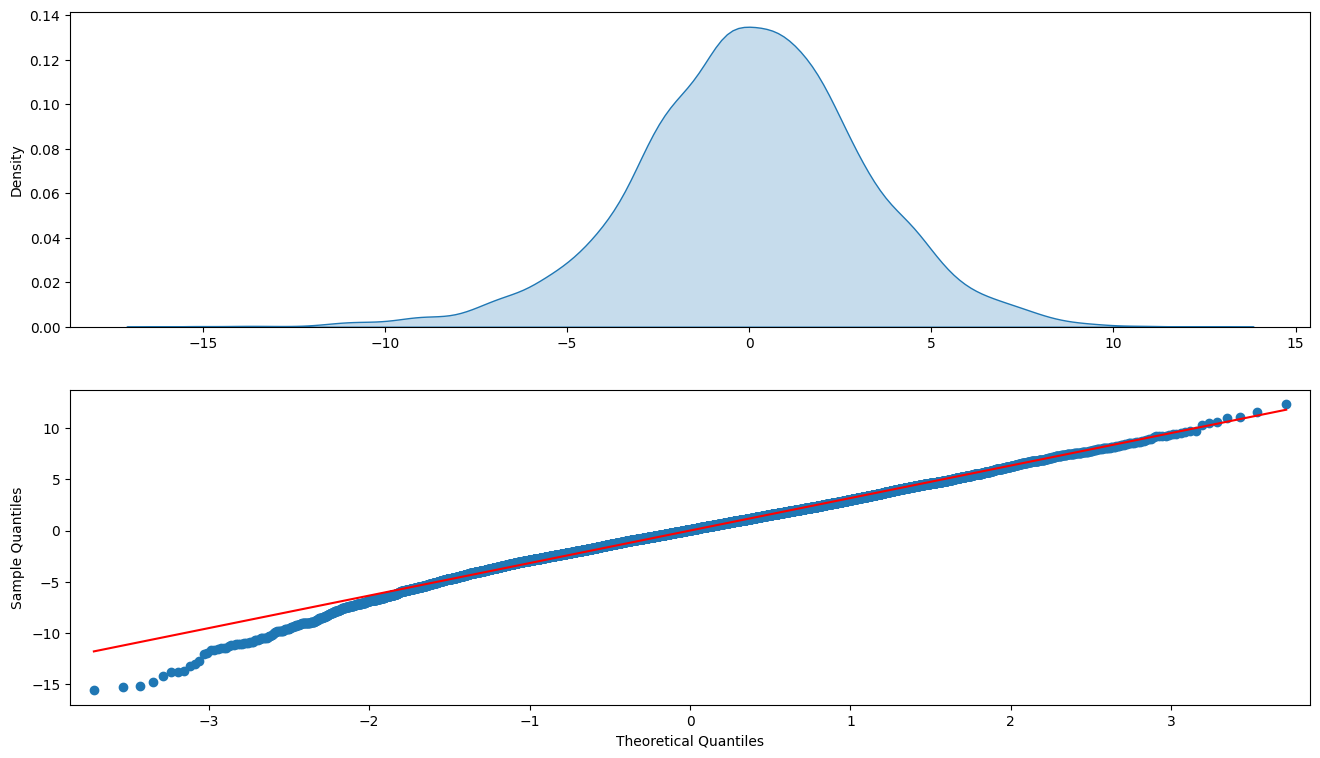

In [16]:
vertical_break = Model("INDUCED_VERTICAL_BREAK ~ SPIN_RATE_ABSOLUTE + RELEASE_SPEED + RELEASE_SIDE + RELEASE_HEIGHT + RELEASE_EXTENSION + HORIZONTAL_APPROACH_ANGLE + VERTICAL_APPROACH_ANGLE", data)
vertical_break.build_model("PITCHER_KEY")
print(vertical_break.get_residuals())
vertical_break.plot_resid()
prob_vertical = vertical_break.compute_prob()
display(prob_vertical)
#vertical_break.shapiro_test()

0       1.932446
1       7.284541
2       5.679286
3       2.700317
4       1.489986
          ...   
9884   -0.749674
9885    1.828753
9886    5.233907
9887   -5.457051
9888    2.827975
Name: residuals, Length: 9889, dtype: float64


,PID,prob_affected
0,197,0.299850
1,348,0.023942
2,1072,0.061484
3,420,0.231664
4,198,0.342862
...,...,...
9884,22663,0.580668
9885,28642,0.309711
9886,22664,0.077590
9887,22665,0.930840


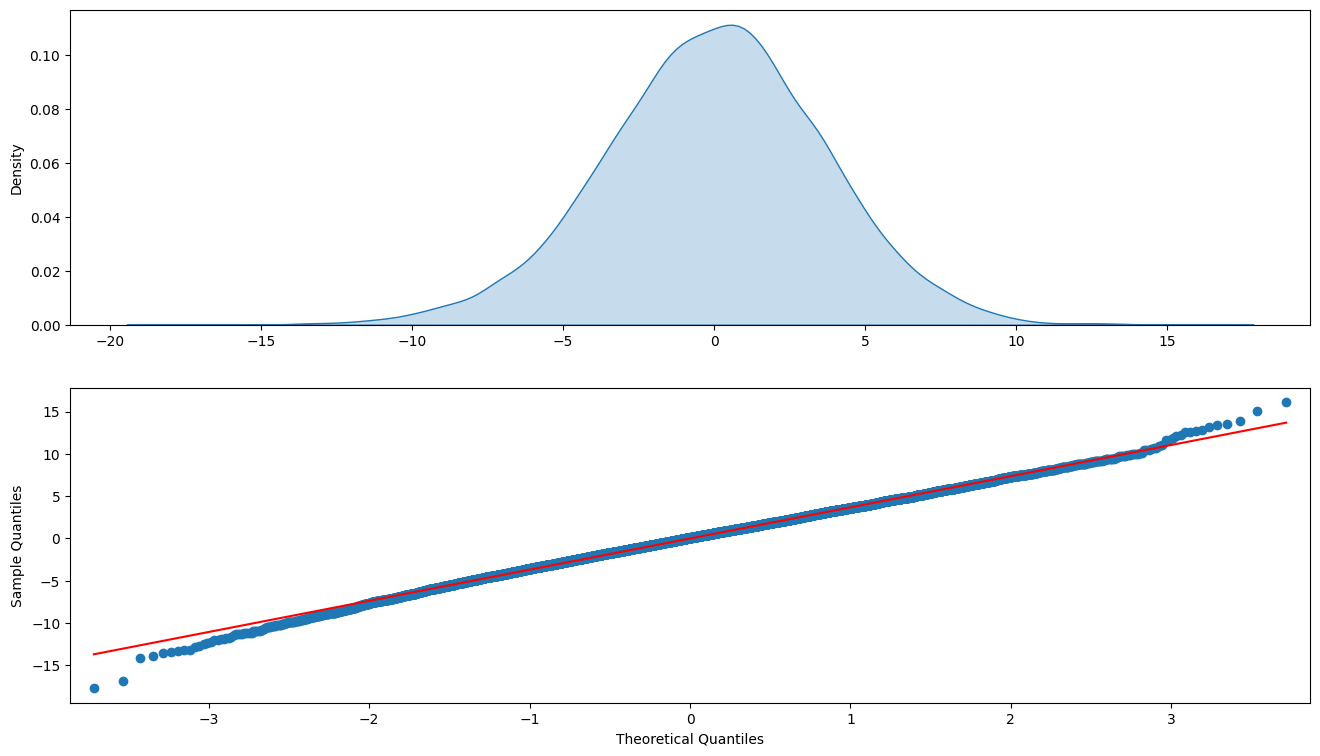

In [17]:
horizontal_break = Model("HORIZONTAL_BREAK ~ SPIN_RATE_ABSOLUTE + RELEASE_SPEED + RELEASE_SIDE + RELEASE_HEIGHT + RELEASE_EXTENSION + HORIZONTAL_APPROACH_ANGLE + VERTICAL_APPROACH_ANGLE", data)
horizontal_break.build_model("PITCHER_KEY")
print(horizontal_break.get_residuals())
horizontal_break.plot_resid()
prob_horizontal = horizontal_break.compute_prob()
display(prob_horizontal)
#vertical_break.shapiro_test()

In [18]:
data['prob_affected'] = (prob_vertical['prob_affected'] + prob_horizontal['prob_affected'])/2
final_prob = data[['PID','prob_affected']]
final_prob

,PID,prob_affected
0,197,0.428863
1,348,0.415556
2,1072,0.323749
3,420,0.429726
4,198,0.508054
...,...,...
9884,22663,0.700784
9885,28642,0.599043
9886,22664,0.361548
9887,22665,0.537981
